### Import Packages

In [95]:
from __future__ import absolute_import, division, print_function
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.io
from time import gmtime, strftime
import random

# TensorFlow and tf.keras
import tensorflow as tf

import aging as age

print(tf.test.gpu_device_name())

# Define directory with matlab files
# direc = 'D:/MLdata/18-01-09d-Exp/Extract Data/'
# direc  = 'D:/Nicholas_ML/18-01-09d-Exp/Extract Data/'
direc = 'D:/MLdata/'
# Define directory to save model and plots
savedir = 'D:/MLdata/Model/' + strftime("%Y-%m-%d %H-%M", gmtime()) + '/'

random.seed(0)
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/device:GPU:0


### Import Data

A lot of things are hidden behind the scenes in this code.  This allows for compactness within the Jupyter notebook.

In order to properly import the data, there are several options which can be varied.

In [96]:
# Optimized Data Extractor
crop_size = 750
split_size = crop_size // 3
clip_value = 1
image_grid_size = int(crop_size**2 / split_size**2)

file_num = 50

folders, files = age.seq_file_names(direc = direc, 
                                which_samples = (0,), 
                                num_exps = file_num)

skip_exp = ['ML_block1_Exp265.mat', 
            'ML_block1_Exp272.mat',
           'ML_block1_Exp278.mat',
           'ML_block1_Exp386.mat',
           'ML_block1_Exp388.mat',
           'ML_block1_Exp392.mat']

for skip in skip_exp:
    files = list(filter((skip).__ne__, files))

['18-01-09d-Exp']


In [97]:
length_index, split_images, label_dic = age.data_extractor(files, 
                     folders, 
                     direc = direc, 
                     crop_size = crop_size, 
                     split_size = split_size,
                     clip_value = clip_value,
                     subtract = True, 
                     log_image = True, 
                     younger = 0)

### Troubleshooting

In [98]:
# age.intensity_plotter(length_index, label_dic, 
#                       split_images, image_grid_size,
#                      normalize_to_1 = True, normalize_all = True, 
#                       log_plot = False)

In [99]:
# age.time_plotter(length_index, files, label_dic, 
#                  split_images, image_grid_size, full = False)
# # age.difference(Fs_label, Fn_label, T_label, split_images, length_index, files, image_grid_size)

### Assemble Data

Test Index Completed...
Training Data and Labels Completed... (11053, 250, 250) (11053, 1)
Testing Data and Labels Completed... (3158, 250, 250) (3158, 1)
Training and Testing Metadata Completed...


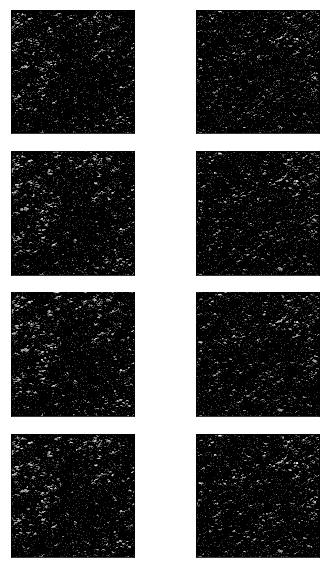

In [100]:
train_data, train_labels, train_meta, test_data, test_labels, test_meta = \
        age.withhold_sqr(
            split_images = split_images, 
            ML_labels = ['T'],
            label_dic = label_dic,
            image_grid_size = image_grid_size, 
            log_time = True,
            cols = int(np.ceil(.2*image_grid_size)))

# train_data, train_labels, train_meta, test_data, test_labels, test_meta = \
#         age.withold_exp(
#             split_images = split_images, 
#             ML_labels = ['T'],
#             label_dic = label_dic,
#             log_time = True)

# train_data, train_labels, test_data, test_labels = \
# age.younger(train_data, train_labels, test_data, test_labels, time_cut = 5)

min_val = np.min([np.min(train_data), np.min(test_data)])

#Final Renormilization of Images to be between 0 and 1
train_data = (train_data - min_val)/(1 - min_val)
test_data = (test_data - min_val)/(1 - min_val)

### Build CNN

In [101]:
image_size = train_data.shape[1]
    
# Create the base model
# https://keras.io/applications/#inceptionv3
base_model = tf.keras.applications.inception_v3.InceptionV3(
                include_top=False, 
                weights='imagenet', 
                input_shape=(image_size,image_size,3))

base_model.trainable = False
    
incep_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.Dropout(rate = 0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.Dropout(rate = 0.3),
    tf.keras.layers.Dense(1),
    tf.keras.layers.LeakyReLU(alpha=0.5)
    ])

#custom_model = tf.keras.Sequential([
#        tf.keras.layers.Conv2D(8, kernel_size=(2, 2),
#                       input_shape=(image_size, image_size, 1)),
#        tf.keras.layers.LeakyReLU(alpha=0.5),
#        tf.keras.layers.Dropout(rate = 0.3),
#        tf.keras.layers.Conv2D(16, (3, 3)),
#        tf.keras.layers.LeakyReLU(alpha=0.5),
#        tf.keras.layers.Dropout(rate = 0.3),
#        tf.keras.layers.Flatten(),
#        tf.keras.layers.Dense(32),
#        tf.keras.layers.LeakyReLU(alpha=0.5),
#        tf.keras.layers.Dropout(rate = 0.3),
#        tf.keras.layers.Dense(1),
#        tf.keras.layers.LeakyReLU(alpha=0.5)

### Train CNN

In [102]:
model, history = age.inception_train(
                    train_data, 
                    train_labels, 
                    test_data, 
                    test_labels,
                    savedir, 
                    incep_model,
                    epochs = 100,
                    patience = 40)

# model, history = age.aion(train_data, train_labels, test_data, test_labels,
#                     savedir, full_model)

Train on 11053 samples, validate on 3158 samples
Epoch 1/100
11053/11053 [==============================] - 47s 4ms/sample - loss: 0.2235 - mean_absolute_error: 1.5927 - acc: 0.0000e+00 - val_loss: 0.4657 - val_mean_absolute_error: 2.2974 - val_acc: 0.0000e+00
Epoch 2/100
11053/11053 [==============================] - 40s 4ms/sample - loss: 0.1658 - mean_absolute_error: 1.3459 - acc: 0.0000e+00 - val_loss: 0.1946 - val_mean_absolute_error: 1.5473 - val_acc: 0.0000e+00
Epoch 3/100
11053/11053 [==============================] - 40s 4ms/sample - loss: 0.1490 - mean_absolute_error: 1.2697 - acc: 0.0000e+00 - val_loss: 0.1050 - val_mean_absolute_error: 1.0216 - val_acc: 0.0000e+00
Epoch 4/100
11053/11053 [==============================] - 40s 4ms/sample - loss: 0.1367 - mean_absolute_error: 1.2165 - acc: 0.0000e+00 - val_loss: 0.0947 - val_mean_absolute_error: 0.9261 - val_acc: 0.0000e+00
Epoch 5/100
11053/11053 [==============================] - 40s 4ms/sample - loss: 0.1278 - mean_absolut

11053/11053 [==============================] - 40s 4ms/sample - loss: 0.0480 - mean_absolute_error: 0.7500 - acc: 0.0000e+00 - val_loss: 0.0782 - val_mean_absolute_error: 0.8629 - val_acc: 0.0000e+00
Epoch 40/100
11053/11053 [==============================] - 40s 4ms/sample - loss: 0.0465 - mean_absolute_error: 0.7516 - acc: 0.0000e+00 - val_loss: 0.1194 - val_mean_absolute_error: 1.1178 - val_acc: 0.0000e+00
Epoch 41/100
11053/11053 [==============================] - 40s 4ms/sample - loss: 0.0466 - mean_absolute_error: 0.7538 - acc: 0.0000e+00 - val_loss: 0.0777 - val_mean_absolute_error: 0.8668 - val_acc: 0.0000e+00
Epoch 42/100
11053/11053 [==============================] - 40s 4ms/sample - loss: 0.0431 - mean_absolute_error: 0.7224 - acc: 0.0000e+00 - val_loss: 0.0919 - val_mean_absolute_error: 0.9529 - val_acc: 0.0000e+00
Epoch 43/100
11053/11053 [==============================] - 40s 4ms/sample - loss: 0.0442 - mean_absolute_error: 0.7249 - acc: 0.0000e+00 - val_loss: 0.1149 - va

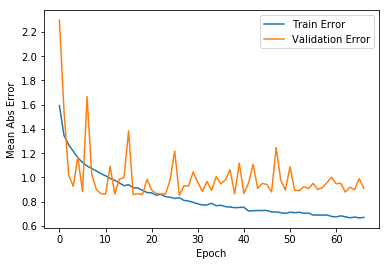

In [105]:
age.hist_plotter(history, savedir + "Incep_history")

### Examine Results

In [104]:
# loaddir = ''
# model = load_model('my_model.h5')
# np.load(savedir + 'length_index',length_index)
# np.load(savedir + "test_data", test_data) 
# np.load(savedir + "train_data",train_data) 
# scipy.io.loadmat(savedir + "test_meta", test_meta) 
# scipy.io.loadmat(savedir + "train_meta", train_meta) 
# train_labels = train_meta['T']
# test_labels = test_meta['T']

In [103]:
test_predic = model.predict(np.tile(
    test_data.reshape(test_data.shape[0], 
    test_data.shape[1], 
    test_data.shape[2], 
    1), 
        3))
train_predic = model.predict(np.tile(train_data.reshape(
    train_data.shape[0], 
    train_data.shape[1],  
    train_data.shape[2], 
    1),
        3))

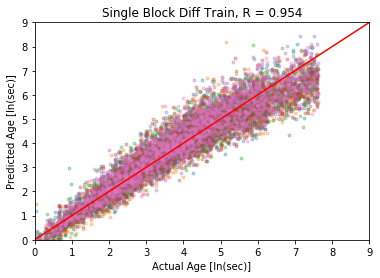

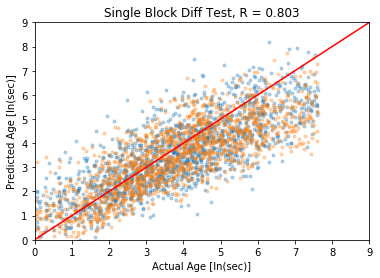

In [113]:
train_times = train_labels.reshape(-1, int(np.floor(.8*image_grid_size)))
train_pred_times = train_predic.reshape(-1, int(np.floor(.8*image_grid_size)))

# train_shear = train_labels[:,1]
# train_pred_shear = train_predic[:,1]

test_times = test_labels.reshape(-1, int(np.ceil(.2*image_grid_size)))
test_pred_times = test_predic.reshape(-1, int(np.ceil(.2*image_grid_size)))

# test_shear = test_labels[:,1]
# test_pred_shear = test_predic[:,1]

age.data_plotter(train_times, train_pred_times, 
                 savedir + "Incep_Age_train" ,
                 name = 'Single Block Diff Train',
                 lim = 9,
                 marker = ".", alpha = .3)

age.data_plotter(test_times, test_pred_times, 
                 savedir + "Incep_Age_test" ,
                 name = 'Single Block Diff Test',
                 lim = 9,
                 marker = ".", alpha = .3)

In [114]:
test_meta['T'] = np.exp(test_labels.flatten())
train_meta['T'] = np.exp(train_labels.flatten())

In [118]:
import scipy.io
np.save(savedir + 'length_index',length_index)
np.save(savedir + "test_data", test_data) 
np.save(savedir + "train_data",train_data) 
scipy.io.savemat(savedir + "test_meta", test_meta) 
scipy.io.savemat(savedir + "train_meta", train_meta) 

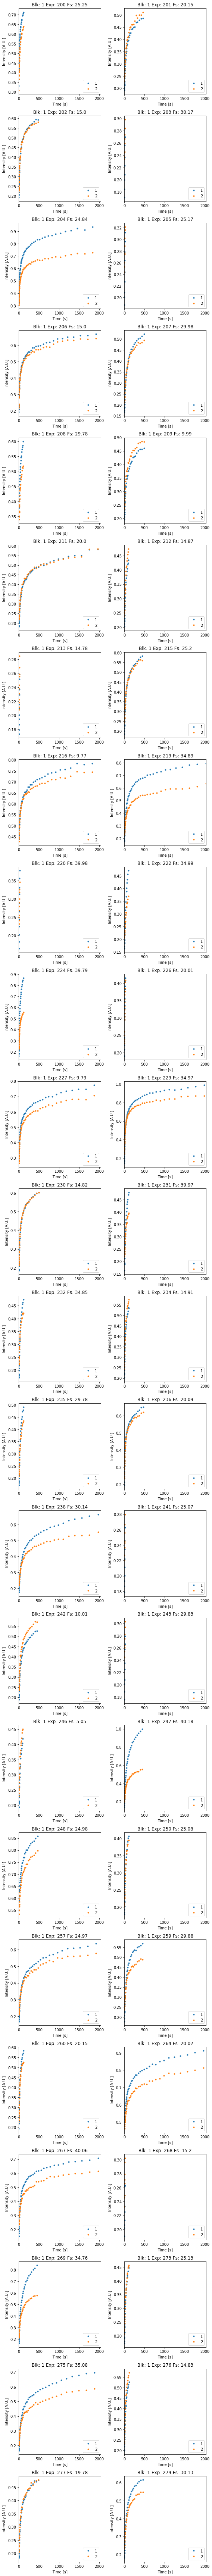

In [108]:
age.intensity_plotter(length_index, test_meta, 
                      test_data, 2,
                     normalize_to_1 = True, normalize_all = False, 
                      log_plot = False)

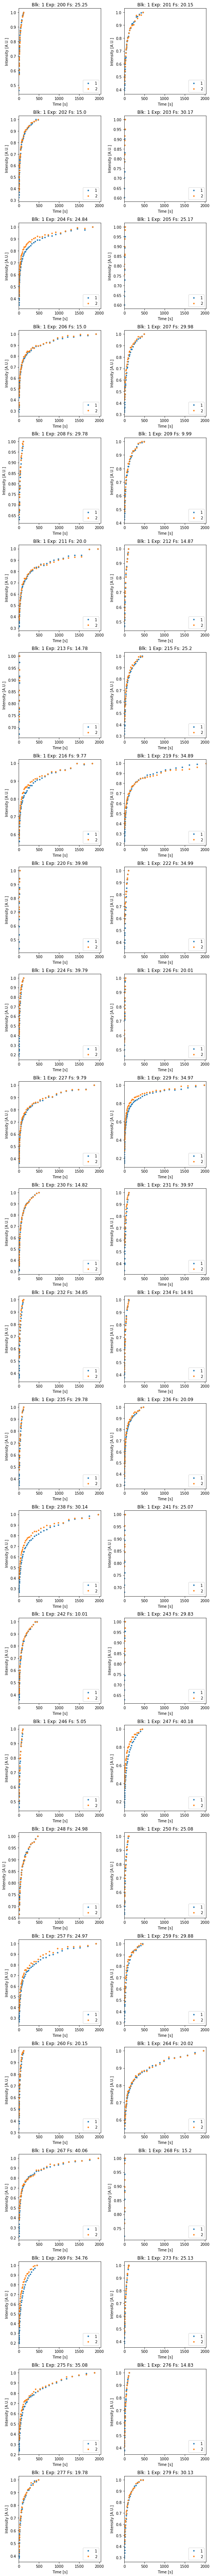

In [109]:
age.intensity_plotter(length_index, test_meta, 
                      test_data, 2,
                     normalize_to_1 = True, normalize_all = True, 
                      log_plot = False)